# Gaussian fit to the spectra of ALMA H$_2$CO($3_{0,3} - 2_{0,2}$) with channels filtered due to missing zero-spacing data

We just combined the two files (the one with the channels filtered out and the one without), we tested this code and it gives the same results for the unfiltered and filtered data. 

We now need to run it with the new range of filtered channels and the criteria of the uncertainty of the central velocities.

Be careful, when you do the fit with all channels, we do not need in the quality assessment to take out the peaks that are within masked channels!

For the all_chans, the 5 sigma threshold for the quality assessment is best. For the fit that masks the central chans, a 3 sigma proved to be best.

In [1]:
%matplotlib inline
import pyspeckit
import numpy as np
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
from spectral_cube import SpectralCube
from skimage.morphology import remove_small_objects, closing, disk, opening, remove_small_holes, dilation
import os
import sys
sys.path.append('../../B5_NOEMA_30m')
import matplotlib.pyplot as plt
import aplpy
from B5setup import *
from scipy.interpolate import griddata

block_reduce was moved to the astropy.nddata.blocks module.  Please update your import statement.


## Preparation of the data

This part must be run for any of the independent sections to work

In [2]:
verbosity = False
mask_missing_scale_chans = True # always do a full run with false first
# Where we estimate the line is
velinit = 8.0
velend = 12.0
velinitrms = 5.9
# where extended emission is dominant
velinit_zero = 9.7 # was 9.6
velend_zero = 10.3 # was 10.4, 

starting_point = (141,139) #x, y
snratio = 5
snratio_qa = 3
multicore = 40
minsizetrim = 50
maxsigma = 0.31 #0.45


imagefile_original = "B5IRS1_H2COa_robust05_multi_3_cut.fits" # we will use the non-pbcor
imagefile = "B5IRS1_H2COa_robust05_multi_3_cut_K"
imagefilecorr = imagefile + '_contcorrected'
imagefilecontinuum = imagefile + '_continuum.fits'

rmsfile = imagefilecorr + '_rms'
snrfile = imagefilecorr + '_snr'
tpeakfile = imagefilecorr + '_Tpeak'
maskfile = imagefilecorr + '_mask'

fitfile =  imagefilecorr + '_1G_fitparams.fits'
newguessfile = imagefilecorr + '_1G_fitparams_guesses.fits'
fitfile2 = imagefilecorr + '_1G_fitparams_2.fits'
fitfile2filtered = imagefilecorr + '_1G_fitparams_2_filtered.fits'
fitfile2filteredTpeak = imagefilecorr + '_1G_fitparams_2_filtered_Tpeak.fits'
fitfile2filteredVlsr = imagefilecorr + '_1G_fitparams_2_filtered_Vlsr.fits'
fitfile2filteredSigmaV = imagefilecorr + '_1G_fitparams_2_filtered_SigmaV.fits'

fitfile2G = imagefilecorr +'_2G_fitparams.fits'
fitfile2Gfiltered =  imagefilecorr + '_2G_fitparams_filtered.fits'
newguessfile2G = imagefilecorr + '_2G_fitparams_guesses.fits'
fitfile22G = imagefilecorr + '_2G_fitparams_2.fits'
fitfile22Gfiltered = imagefilecorr + '_2G_fitparams_2_filtered.fits'
fitfile22GfilteredTpeak = imagefilecorr + '_2G_fitparams_2_filtered_Tpeak.fits'
fitfile22GfilteredVlsr = imagefilecorr + '_2G_fitparams_2_filtered_Vlsr.fits'
fitfile22GfilteredSigmaV = imagefilecorr + '_2G_fitparams_2_sigmafiltered_SigmaV.fits'

fitfile3G =  imagefilecorr + '_3G_fitparams.fits'
fitfile3Gfiltered =  imagefilecorr + '_3G_fitparams_filtered.fits'
newguessfile3G = imagefilecorr + '_3G_fitparams_guesses.fits'
fitfile23G = imagefilecorr + '_3G_fitparams_2.fits'
fitfile23Gfiltered = imagefilecorr + '_3G_fitparams_2_filtered.fits'

if mask_missing_scale_chans:
    # this is the folder path we add for the ones that have channels masked
    folder = 'central_chans_masked/'
    
    # we edit just in case it is true
    # now the mask is different, is 3D, as we need to mask out certain channels
    maskfile = folder + maskfile

    imagefilecorrmasked = folder + imagefilecorr +'_masked.fits'
    fitfile =  folder + fitfile
    initguessfile1G = 'all_chans/' + imagefilecorr + '_1G_fitparams_2_filtered.fits' # when we use this file, there are less gnorm errors and the quality of the fit is greater (more points are fitted)
    newguessfile = folder + newguessfile
    fitfile2 = folder + fitfile2
    fitfile2filtered = folder + fitfile2filtered
    fitfile2filteredTpeak = folder + fitfile2filteredTpeak
    fitfile2filteredVlsr = folder + fitfile2filteredVlsr
    fitfile2filteredSigmaV = folder + fitfile2filteredSigmaV  
    
    fitfile2G = folder + fitfile2G
    fitfile2Gfiltered = folder + fitfile2Gfiltered
    initguessfile2G = 'all_chans/' + imagefilecorr + '_2G_fitparams_2_filtered.fits' # we use the results of the non-masked channels fits as initguesses
    newguessfile2G = folder + newguessfile2G
    fitfile22G = folder + fitfile22G
    fitfile22Gfiltered = folder + fitfile22Gfiltered
    fitfile22GfilteredTpeak = folder + fitfile22GfilteredTpeak
    fitfile22GfilteredVlsr = folder + fitfile22GfilteredVlsr
    fitfile22GfilteredSigmaV = folder +  fitfile22GfilteredSigmaV
    
    fitfile3G =  folder + fitfile3G
    fitfile3Gfiltered =  folder + fitfile3Gfiltered
    initguessfile3G = 'all_chans/' + imagefilecorr + '_3G_fitparams_guesses.fits' # we use the guesses of the non-masked channels fits as initguesses
    newguessfile3G = folder + newguessfile3G
    fitfile23G = folder + fitfile23G
    fitfile23Gfiltered = folder + fitfile23Gfiltered
    

In [3]:
# convert the file from Jy/beam to k
if not os.path.exists(imagefile+'.fits'):
    print('Creating file in K')
    imagecube = SpectralCube.read(imagefile_original).with_spectral_unit(u.km/u.s)
    kelvincube = imagecube.to(u.K)
    kelvincube.hdu.writeto(imagefile+'.fits')

In [4]:
# we try the continuum corrected fitting
if not os.path.exists(imagefilecorr + '.fits'):
    print('Creating continuum correct')
    cube = SpectralCube.read(imagefile + '.fits')    
    spectral_axis = cube.spectral_axis
    good_channels = (spectral_axis < 7.8 * u.km / u.s) | (spectral_axis > 12.5 * u.km / u.s)  
    masked_cube = cube.with_mask(good_channels[:, np.newaxis, np.newaxis])  
    med = masked_cube.median(axis=0)
    if not os.path.exists(imagefilecontinuum):
        med.write(imagefilecontinuum)
    med_subcube = cube - med
    med_subcube.write(imagefilecorr + '.fits')

cube = pyspeckit.Cube(imagefilecorr + '.fits')


In [5]:
header = cube.header
hdcube = cube.header.copy()
wcs = WCS(header)
key_remove = ['NAXIS3','CRPIX3','CDELT3','CUNIT3','CTYPE3','CRVAL3','SPECSYS']
for key_i in key_remove:
    hdcube.remove(key_i)
hdcube['WCSAXES'] = 2
hdcube['NAXIS'] = 2

if not os.path.exists(rmsfile+'.fits'):
    rmsmap = cube.slice(velinitrms, velinit, unit='km/s').cube.std(axis=0)
    fits.writeto(rmsfile+'.fits', rmsmap, hdcube)
    print('Created RMS file')
else:
    rmsmap = fits.getdata(rmsfile+'.fits')

if not os.path.exists(tpeakfile+'.fits'):
    Tpeakmap = cube.slice(velinit, velend, unit='km/s').cube.max(axis=0)
    fits.writeto(tpeakfile+'.fits', Tpeakmap, hdcube)
    print('Created Tpeak file')
else:
    Tpeakmap = fits.getdata(tpeakfile+'.fits')

if not os.path.exists(snrfile+'.fits'):
    snrmap = Tpeakmap / rmsmap
    hdcubesnr = hdcube.copy()
    hdcubesnr['BUNIT'] = ''
    fits.writeto(snrfile+'.fits', snrmap, hdcubesnr)
    print('Created SNR file')
else:
    snrmap = fits.getdata(snrfile+'.fits')

print('Loaded initial files: Tpeak, rms, SNR')
    

Loaded initial files: Tpeak, rms, SNR


In [6]:
if not os.path.exists(maskfile+'.fits'):
    print("Creating mask file")
    planemask = (snrmap > snratio)
    # check the resulting mask map to see how much does the minimum size have to be and its connectivity
    # before applying this filter
    planemask = remove_small_objects(planemask, min_size=minsizetrim)
    planemask = remove_small_holes(planemask, area_threshold=minsizetrim)
    planemask = closing(planemask, disk(3))
    planemask = remove_small_holes(planemask, area_threshold=minsizetrim*4)
    planemask = opening(planemask, disk(4))
    # we just save this mask as a plane
    hdcube['BUNIT'] = ''
    fits.writeto(maskfile+'.fits', planemask.astype(int), hdcube)
    print("Wrote 2D mask file")

else:
    print("Loading 2D mask file")
    planemask = fits.getdata(maskfile+'.fits').astype(bool)

if mask_missing_scale_chans:
    if not os.path.exists(imagefilecorrmasked):
        data = cube.cube
        planeinit, planeend = wcs.spectral.all_world2pix([[velend_zero*1e3], [velinit_zero*1e3]], 0)
        data[int(planeinit):int(planeend), :, :] = np.nan
        fits.writeto(imagefilecorrmasked, data, cube.header)
    cube = pyspeckit.Cube(imagefilecorrmasked)
    print("Loaded cube with channels with missing zero-spacing emission masked.")

cube.maskmap = planemask
print("Added 2D mask to cube.maskmap")

print('Loaded initial files: Tpeak, rms, SNR')
    

Loading 2D mask file
Loaded cube with channels with missing zero-spacing emission masked.
Added 2D mask to cube.maskmap
Loaded initial files: Tpeak, rms, SNR


## Functions

These functions will allow to filter and interpolate solutions. Also must be run for the independent sections to work

### Quality assessment filter for Gaussian fittings

In [7]:
def filtersolutions(parcube, errcube, npeaks, rmsmap=None, snratio=None, 
                    velinit=-np.inf, velend=np.inf, filter_negative=False, 
                    errorfrac=None, eps=1.e-6, filter_islands=False, 
                    minsizetrim=50, chansize=0.08, masked_chans=False, 
                    velinit_mask=None, velend_mask=None):
    """
    Replace the pixels in the fitted cube with np.nan where the fit is not
    good enough according to our criteria.

    The criteria that a pixel must have are:
    - The errors are not zero (less than eps)
    - The peak must not be negative in case filter_negatives is true
    - The error fraction is lower than errorfrac, if given
    - The central velocity value must be within the range [velinit,velend]
    - The peak value must be larger than rms times snratio, if given
    - If one parameter in a spectra is np.nan, all the spectra must be nan (sanity
    check)
    - NEW 10.5.22: the uncertainty in the central velocity must be smaller than the channel width
    - NEW 11.5.22: if we masked certain channels, the central velocity of the components must not be within those channels

    Args:
        variable (type): description

    Returns:
        type: description

    Raises:
        Exception: description

    """
    # we first create all the masks we need
    
    # all errors must be non zero
    # note that eps must be larger than the velocity dispersion
    zeromask = np.zeros(np.shape(parcube[0]), dtype=int) # we need to do a plane mask
    for i in range(3*npeaks):
        zeromask += np.where(np.abs(errcube[i])<eps, 1, 0)
        
    # if a fraction is given, make sure all values have an error fraction less than that
    errormask = np.zeros(np.shape(parcube[0]), dtype=int)
    if errorfrac is not None:
        for i in range(3*npeaks):
            errormask += np.where(np.abs(errcube[i]/parcube[i]) > errorfrac, 1, 0)
            
    
    # if indicated, all values must be non-negative
    negativemask = np.zeros(np.shape(zeromask), dtype=int)
    if filter_negative:
        for i in range(3*npeaks):
            negativemask += np.where(parcube[i] < 0, 1, 0)
    
    # velocities must be within range
    velocitymask = np.zeros(np.shape(zeromask), dtype=int)
    for i in range(npeaks):
        velocitymask += np.where(parcube[1+3*i] < velinit, 1, 0) + \
        np.where(parcube[1+3*i] > velend, 1, 0)
    
    # the amplitude of the Gaussian must be above the snratio indicated
    peakmask = np.zeros(np.shape(zeromask), dtype=int)
    if snratio is not None and rmsmap is not None:
        for i in range(npeaks):
            snrmappeak = parcube[3*i] / rmsmap
            peakmask += np.where(snrmappeak < snratio, 1, 0)
    
    # all values of parameters and uncertainties must be not NaN
    nanmask = np.zeros(np.shape(zeromask), dtype=int)
    for i in range(3*npeaks):
        nanmask += np.where(np.isnan(parcube[i]), 1, 0) + np.where(np.isnan(errcube[i]), 1, 0)
    
    # central velocity uncertainty must be lower than
    centraluncertaintymask = np.zeros(np.shape(zeromask), dtype=int)
    for i in range(npeaks):
        velocitymask += np.where(errcube[1+3*i] > chansize, 1, 0)
        
    # if indicated, the central velocities must not be within masked channels
    maskedchansmask = np.zeros(np.shape(zeromask), dtype=int)
    if masked_chans:
        for i in range(npeaks):
            maskedchansmask += np.where(parcube[1+3*i] > velinit_mask, 1, 0) * np.where(parcube[1+3*i] < velend_mask, 1, 0)
    
    finalmask = zeromask + errormask + negativemask + velocitymask + peakmask + nanmask + centraluncertaintymask + maskedchansmask
    
    parcubenew = parcube.copy()
    errcubenew = errcube.copy()
    parcubenew[np.where(np.repeat([finalmask], 3*npeaks, axis=0))] = np.nan
    errcubenew[np.where(np.repeat([finalmask], 3*npeaks, axis=0))] = np.nan   
    
    # eliminate isolated small islands of emission after the filter
    if filter_islands:        
        planemask = ~np.isnan(parcubenew[0])
        planemask = remove_small_objects(planemask, min_size=minsizetrim)
        smallmask = np.ones(np.shape(planemask), dtype=int) - planemask
        parcubenew[np.where(np.repeat([smallmask], 3*npeaks, axis=0))] = np.nan
        errcubenew[np.where(np.repeat([smallmask], 3*npeaks, axis=0))] = np.nan
    
    return parcubenew, errcubenew


### Interpolation of parameters to obtain improved initial guesses

In [8]:
# as each plane represents a different physical characteristic, and they do not necessarilly 
# correlate between each other, each plane of initguesses must be fit separately
def interpolatesolutions(solfilein, npeaks, mask=None):
    '''
    The solfilein must be a .fits file that contains one parameter per 
    plane and then one parameter uncertainty per plane.
    The shape must be [nplane, yy, xx]
    The mask must be 2 dimensional
    '''
    solcube = fits.getdata(solfilein)[:3*npeaks]
    if np.any(np.isnan(solcube)):
        solcube[np.where(np.isnan(solcube))] = 0
    solcubeshape = np.shape(solcube)
    yy, xx = np.indices(solcubeshape[1:])
    filledcube = solcube.copy()
    headersolcube = fits.getheader(solfilein)

    for i, plane in enumerate(solcube):
        indexknown = np.where(plane<1e-5, False, True)
        filledcube[i][~indexknown] = griddata((xx[indexknown], yy[indexknown]),
                                                  plane[indexknown],
                                                  (xx[~indexknown], yy[~indexknown])
                                                 )
        if mask is not None:
            filledcube[i][np.where(mask==0)] = np.nan
    return filledcube, headersolcube


## 1 Gaussian fit

### First fit: initial guesses fixed

In [9]:
# initial guesses for the first two gaussian fit

# if mask_missing_scale_chans:
#     initguesses = [10.0, 9.6, 0.8]
if mask_missing_scale_chans:
    initguesses, headerguess = interpolatesolutions(initguessfile1G, 1, mask=planemask)
else:
    initguesses = [10.0, 10.2, 0.8]
limitedmin = [True, True, True]
limitedmax = [False, True, False]
limitsmin = [0, velinit, 0]
limitsmax = [0, velend, velend-velinit]

if not os.path.exists(fitfile):
    print("Starting fit")
    cube.fiteach(fittype='gaussian',
                 guesses=initguesses,
                 signal_cut=snratio,
                 errmap = rmsmap,
                 limitedmin=limitedmin,
                 limitedmax=limitedmax,
                 minpars=limitsmin,
                 maxpars=limitsmax,
                 use_neighbor_as_guess=True, 
                 start_from_point=starting_point,
                 verbose=verbosity,
                 verbose_level=1,
                 multicore=multicore)
    cube.write_fit(fitfile)
    fittedmodel = cube.get_modelcube()
    
else:
    print("Fit exists. Loading")
    cube.load_model_fit(fitfile, 3, fittype='gaussian')

Fit exists. Loading


NaN or infinite values encountered in parameter cube.


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]


### Second fit: Extrapolation

We do not do a quality assesment yet. We extrapolate the best fit results to fill in the gaps in the mask

In [10]:
if not os.path.exists(newguessfile):
    print("Interpolating previous solutions.")
    newinitguess, headerguess = interpolatesolutions(fitfile, 1, mask=planemask)
    fits.writeto(newguessfile, newinitguess, headerguess)
    
else:
    print("Interpolation exists. Loading.")
    newinitguess = fits.getdata(newguessfile)
    

Interpolation exists. Loading.


In [11]:
if not os.path.exists(fitfile2):
    print("Starting fit (S/N>3)")
    cube.fiteach(fittype='gaussian',
                 guesses=newinitguess,
                 errmap = rmsmap, 
                 limitedmin=limitedmin,
                 limitedmax=limitedmax,
                 minpars=limitsmin,
                 maxpars=limitsmax,
                 use_neighbor_as_guess=True, 
                 start_from_point=starting_point,
                 verbose=verbosity,
                 verbose_level=1,
                 multicore=multicore)
    cube.write_fit(fitfile2)
    fittedmodel = cube.get_modelcube()
    
else:
    print("Fit 2 exists. Loading")
    cube.load_model_fit(fitfile2, 3, fittype='gaussian')

Fit 2 exists. Loading
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]


NaN or infinite values encountered in parameter cube.


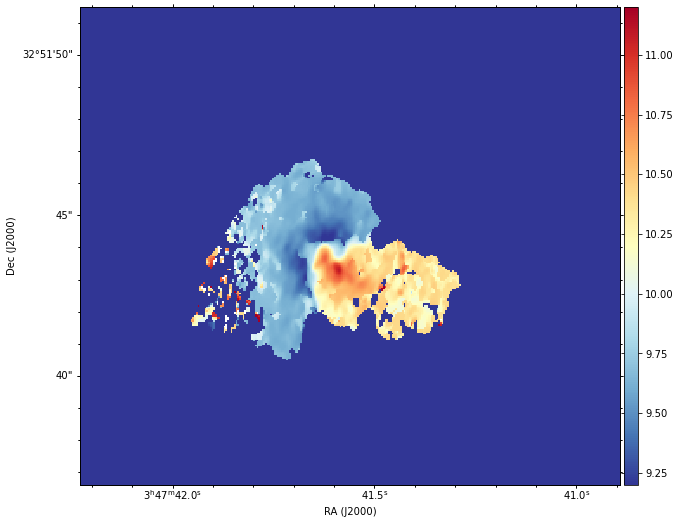

In [12]:
# first look at the velocities before filtering
gc = aplpy.FITSFigure(fits.PrimaryHDU(cube.parcube[1], hdcube))
gc.show_colorscale(cmap='RdYlBu_r', vmin=9.2, vmax=11.2)
gc.add_colorbar()
# gc.show_contour('../cont_image/B5IRS1_cont_natural.fits', colors='w', levels=0.00005*np.array([5, 15, 25]))

Do not let the apparent red-blue rotation within the continuum distract you, there might be two gaussian components or a strong self-absorption for what can be seen in the spectra there (see view_gaussfit_interactive.py)

### Quality Assesment

In [13]:
# we apply the filter
if not os.path.exists(fitfile2filtered):
    print("Creating filtered version.") # for 1G, the snr will always be 3
    parcube, errcube = filtersolutions(cube.parcube, cube.errcube, 1, 
                                       rmsmap=rmsmap, snratio=3, 
                                       velinit=velinit, velend=velend, 
                                       filter_negative=True, errorfrac=0.5, 
                                       filter_islands=True, chansize=0.08, masked_chans=mask_missing_scale_chans, 
                                       velinit_mask=velinit_zero, velend_mask=velend_zero)
    cube.parcube = parcube
    cube.errcube = errcube
    cube.write_fit(fitfile2filtered) #(fitfile2filtered)
    fittedmodel = cube.get_modelcube()
        
else:
    print("Loading filtered version.")
    cube.load_model_fit(fitfile2filtered, 3, fittype='gaussian')
    fittedmodel = cube.get_modelcube()

    
if not os.path.exists(fitfile2filteredTpeak):
    print("Saving Tpeak fit (filtered)")
    hdcube['BUNIT'] = 'K'
    fits.writeto(fitfile2filteredTpeak, cube.parcube[0], hdcube)
    
if not os.path.exists(fitfile2filteredVlsr):
    print("Saving Vlsr fit (filtered)")
    hdcube['BUNIT'] = 'km s-1'
    fits.writeto(fitfile2filteredVlsr, cube.parcube[1], hdcube)
    
if not os.path.exists(fitfile2filteredSigmaV):
    print("Saving SigmaV fit (filtered)")
    hdcube['BUNIT'] = 'km s-1'
    fits.writeto(fitfile2filteredSigmaV, cube.parcube[2], hdcube)


Loading filtered version.
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]


NaN or infinite values encountered in parameter cube.
Guesses have been changed from [nan, nan, nan] to [nan, nan, nan]


In [14]:
if not mask_missing_scale_chans:
    fitfile2sigmafiltered = imagefilecorr + '_1G_fitparams_2_sigmafiltered.fits'
    fitfile2sigmafilteredTpeak = imagefilecorr + '_1G_fitparams_2_sigmafiltered_Tpeak.fits'
    fitfile2sigmafilteredVlsr = imagefilecorr + '_1G_fitparams_2_sigmafiltered_Vlsr.fits'
    fitfile2sigmafilteredSigmaV = imagefilecorr + '_1G_fitparams_2_sigmafiltered_SigmaV.fits'
    fitfile2sigmafilteredSigmaNT = imagefilecorr + '_1G_fitparams_2_sigmafiltered_SigmaNT.fits'
    fitfile2sigmafilteredMachs = imagefilecorr + '_1G_fitparams_2_sigmafiltered_Mach_s.fits'

    # we also apply a filter where we eliminate all curves with sigma larger than xx km/s

    if not os.path.exists(fitfile2sigmafiltered):
        print("Filtering curves with sigma_v>"+str(maxsigma)+' km/s')
        sigmamask = np.where(cube.parcube[2]>maxsigma, 1, 0)
        cube.parcube[np.where(np.repeat([sigmamask], 3, axis=0))] = np.nan
        cube.errcube[np.where(np.repeat([sigmamask], 3, axis=0))] = np.nan
        cube.write_fit(fitfile2sigmafiltered)
        fittedmodel = cube.get_modelcube()

    else:
        print("File with sigma_v>"+str(maxsigma)+' km/s filtered exists')
        cube.load_model_fit(fitfile2sigmafiltered, 3, fittype='gaussian')
        fittedmodel = cube.get_modelcube()

    # save the different parameters in individual fits for more comfortable use

    if not os.path.exists(fitfile2sigmafilteredTpeak):
        print("Saving Tpeak fit (sigma filtered)")
        hdcube['BUNIT'] = 'K'
        fits.writeto(fitfile2sigmafilteredTpeak, cube.parcube[0], hdcube)

    if not os.path.exists(fitfile2sigmafilteredVlsr):
        print("Saving Vlsr fit (sigma filtered)")
        hdcube['BUNIT'] = 'km s-1'
        fits.writeto(fitfile2sigmafilteredVlsr, cube.parcube[1], hdcube)

    if not os.path.exists(fitfile2sigmafilteredSigmaV):
        print("Saving SigmaV fit (sigma filtered)")
        hdcube['BUNIT'] = 'km s-1'
        fits.writeto(fitfile2sigmafilteredSigmaV, cube.parcube[2], hdcube)


The one Gaussian fit is exactly the same as when we considered the channels affected by missing scales

## 2 Gaussian fit

Motivated by the results of the first fit, we explore what is going on in the center, where we masked before. We can find resolved structures if we explore a 2 Gaussian fit

In [15]:
snratio = 5


### First fit: 2 Gaussians with the previous results (unmasked channels) as initial guess

In [16]:
# initial guesses for the first two gaussian fit

#we interpolate for the missing parts
if mask_missing_scale_chans:
    initguesses, headerguess2 = interpolatesolutions(initguessfile2G, 2, mask=planemask)
    # manual input of some areas
    initguesses[0, 134:143, 145:154] = 8.
    initguesses[1, 134:143, 145:154] = 11.5
    initguesses[2, 134:143, 145:154] = 0.2
    initguesses[3, 134:143, 145:154] = 10.
    initguesses[4, 134:143, 145:154] = 9.38
    initguesses[5, 134:143, 145:154] = 0.15
    
    initguesses[0, 118:125, 139:145] = 8.
    initguesses[1, 118:125, 139:145] = 11.5
    initguesses[2, 118:125, 139:145] = 0.2
    initguesses[3, 118:125, 139:145] = 10.
    initguesses[4, 118:125, 139:145] = 9.38
    initguesses[5, 118:125, 139:145] = 0.15
    
    initguesses[0, 114:122, 150:160] = 5.
    initguesses[1, 114:122, 150:160] = 11.45
    initguesses[2, 114:122, 150:160] = 0.1
    initguesses[3, 114:122, 150:160] = 8.
    initguesses[4, 114:122, 150:160] = 10.63
    initguesses[5, 114:122, 150:160] = 0.2
    
else:
    imageshape = np.shape(cube.cube)
    initguesses = np.zeros((6, imageshape[1], imageshape[2]))
    initguesses[0, :, :] = 10.0
    initguesses[1, :, :] = 10.5
    initguesses[2, :, :] = 0.3
    initguesses[3, :, :] = 10.0
    initguesses[4, :, :] = 9.2
    initguesses[5, :, :] = 0.3
    #initguesses[] = [10.0, 10.5, 0.3, 10, 9.2, 0.3]
    # manual input of some areas
    initguesses[0, 116:145, 115:128] = 10.0 
    initguesses[1, 116:145, 115:128] = 9.8
    initguesses[2, 116:145, 115:128] = 0.1 
    initguesses[3, 116:145, 115:128] = 10
    initguesses[4, 116:145, 115:128] = 9.3
    initguesses[5, 116:145, 115:128] = 0.1
    
    initguesses[0, 80:127, 116:138] = 7
    initguesses[1, 80:127, 116:138] = 10.13
    initguesses[2, 80:127, 116:138] = 0.1 
    initguesses[3, 80:127, 116:138] = 8
    initguesses[4, 80:127, 116:138] = 9.38
    initguesses[5, 80:127, 116:138] = 0.1
    
    initguesses[0, 65:100, 107:119] = 6
    initguesses[1, 65:100, 107:119] = 10.0
    initguesses[2, 65:100, 107:119] = 0.1 
    initguesses[3, 65:100, 107:119] = 6
    initguesses[4, 65:100, 107:119] = 9.54
    initguesses[5, 65:100, 107:119] = 0.1
    
    initguesses[0, 116:130, 148:154] = 5
    initguesses[1, 116:130, 148:154] = 11.3
    initguesses[2, 116:130, 148:154] = 0.1 
    initguesses[3, 116:130, 148:154] = 6
    initguesses[4, 116:130, 148:154] = 10.5
    initguesses[5, 116:130, 148:154] = 0.1
    
    initguesses[0, 116:126, 141:158] = 6
    initguesses[1, 116:126, 141:158] = 11.4
    initguesses[2, 116:126, 141:158] = 0.1 
    initguesses[3, 116:126, 141:158] = 6
    initguesses[4, 116:126, 141:158] = 10.72
    initguesses[5, 116:126, 141:158] = 0.2
    
    initguesses[0, 129:143, 113:128] = 7
    initguesses[1, 129:143, 113:128] = 9.8
    initguesses[2, 129:143, 113:128] = 0.1 
    initguesses[3, 129:143, 113:128] = 11
    initguesses[4, 129:143, 113:128] = 9.3
    initguesses[5, 129:143, 113:128] = 0.1
    
    initguesses[0, 155:161, 134:139] = 5
    initguesses[1, 155:161, 134:139] = 9.88
    initguesses[2, 155:161, 134:139] = 0.1 
    initguesses[3, 155:161, 134:139] = 7
    initguesses[4, 155:161, 134:139] = 9.46
    initguesses[5, 155:161, 134:139] = 0.1
    
    initguesses[0, 87:91, 103:115] = 6
    initguesses[1, 87:91, 103:115] = 9.97
    initguesses[2, 87:91, 103:115] = 0.1 
    initguesses[3, 87:91, 103:115] = 6.5
    initguesses[4, 87:91, 103:115] = 9.6
    initguesses[5, 87:91, 103:115] = 0.1
    
    initguesses[0, 125:130, 120:124] = 6
    initguesses[1, 125:130, 120:124] = 9.88
    initguesses[2, 125:130, 120:124] = 0.15
    initguesses[3, 125:130, 120:124] = 10
    initguesses[4, 125:130, 120:124] = 9.29
    initguesses[5, 125:130, 120:124] = 0.3
    
    initguesses[0, 149:156, 146:156] = 4
    initguesses[1, 149:156, 146:156] = 9.93
    initguesses[2, 149:156, 146:156] = 0.15
    initguesses[3, 149:156, 146:156] = 10
    initguesses[4, 149:156, 146:156] = 9.4
    initguesses[5, 149:156, 146:156] = 0.25
    
    initguesses[0, 125:152, 127:134] = 6
    initguesses[1, 125:152, 127:134] = 9.56
    initguesses[2, 125:152, 127:134] = 0.1
    initguesses[3, 125:152, 127:134] = 8
    initguesses[4, 125:152, 127:134] = 9.2
    initguesses[5, 125:152, 127:134] = 0.1

In [17]:

limitedmin = [True, True, True, True, True, True]
limitedmax = [False, True, True, False, True, True]
limitsmin = [2, velinit, 0.08, 2, velinit, 0.08]
limitsmax = [0, velend, (velend-velinit)/2.35, 0, velend, (velend-velinit)/2.35]

if not os.path.exists(fitfile2G):
    print("Starting 2G fit")
    cube.fiteach(fittype='gaussian',
                 guesses=initguesses,
                 signal_cut=snratio,
                 errmap = rmsmap,
                 limitedmin=limitedmin,
                 limitedmax=limitedmax,
                 minpars=limitsmin,
                 maxpars=limitsmax,
                 use_neighbor_as_guess=False, 
                 start_from_point=starting_point,
                 verbose=verbosity,
                 verbose_level=1,
                 multicore=multicore)
    cube.write_fit(fitfile2G)
    fittedmodel = cube.get_modelcube()
    
else:
    print("Fit exists. Loading")
    cube.load_model_fit(fitfile2G, 3, npeaks=2, fittype='gaussian')

Fit exists. Loading
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]


### Second fit: interpolation of initial fit

In [18]:
# we apply the filter
if not os.path.exists(fitfile2Gfiltered):
    print("Creating filtered version of initial guesses.")
    parcube, errcube = filtersolutions(cube.parcube, cube.errcube, 2, 
                                       rmsmap=rmsmap, snratio=2, 
                                       velinit=velinit, velend=velend, 
                                       filter_negative=True, errorfrac=0.5, masked_chans=mask_missing_scale_chans, 
                                       velinit_mask=velinit_zero, velend_mask=velend_zero)
    cube.parcube = parcube
    cube.errcube = errcube
    cube.write_fit(fitfile2Gfiltered)
    fittedmodel = cube.get_modelcube()
        
else:
    print("Loading filtered version.")
    cube.load_model_fit(fitfile2Gfiltered, 3, npeaks=2, fittype='gaussian')
    fittedmodel = cube.get_modelcube()
    

Loading filtered version.
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]


NaN or infinite values encountered in parameter cube.
Guesses have been changed from [nan, nan, nan, nan, nan, nan] to [nan, nan, nan, nan, nan, nan]


In [19]:

if not os.path.exists(newguessfile2G):
    print("Interpolating previous 2 Gaussian solutions.")
    newinitguess2G, headerguess2G = interpolatesolutions(fitfile2Gfiltered, 2, mask=planemask) # will work independent of the case
    
    #if not mask_missing_scale_chans:
    # we edit manually some of the points in the velocities
        # xinit = 124
        # xfin = 152
        # yinit = 134
        # yfin = 146
        # newinitguess2G[0][yinit:yfin,xinit:xfin] = 6
        # newinitguess2G[1][yinit:yfin,xinit:xfin] = 9.6
        # newinitguess2G[2][yinit:yfin,xinit:xfin] = 0.1
        # newinitguess2G[3][yinit:yfin,xinit:xfin] = 6
        # newinitguess2G[4][yinit:yfin,xinit:xfin] = 9.1
        # newinitguess2G[5][yinit:yfin,xinit:xfin] = 0.1
    # checks that values do not go beyond limits
    newinitguess2G[2][np.where(newinitguess2G[2]>=1)] = 0.9
    newinitguess2G[5][np.where(newinitguess2G[5]>=1)] = 0.9    
    newinitguess2G[2][np.where(newinitguess2G[2]<=0.08)] = 0.08
    newinitguess2G[5][np.where(newinitguess2G[5]<=0.08)] = 0.08
    fits.writeto(newguessfile2G, newinitguess2G, headerguess2G)
    
else:
    print("Interpolation exists. Loading.")
    newinitguess2G = fits.getdata(newguessfile2G)
    
if not os.path.exists(fitfile22G):
    print("Starting 2 Gaussian fit (S/N>3)")
    cube.fiteach(fittype='gaussian',
                 guesses=newinitguess2G,
                 errmap = rmsmap, 
                 limitedmin=limitedmin,
                 limitedmax=limitedmax,
                 minpars=limitsmin,
                 maxpars=limitsmax,
                 use_neighbor_as_guess=True, 
                 start_from_point=starting_point,
                 verbose=verbosity,
                 verbose_level=0,
                 multicore=multicore)
    cube.write_fit(fitfile22G)
    fittedmodel = cube.get_modelcube()
    
else:
    print("Fit 2 exists. Loading")
    cube.load_model_fit(fitfile22G, 3, npeaks=2, fittype='gaussian')

Interpolation exists. Loading.
Fit 2 exists. Loading
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]


### Quality Assessment of the 2 Gaussian fit

In [20]:
# we apply the filter
if not os.path.exists(fitfile22Gfiltered):
    print("Creating filtered version of the 2 Gaussian fit.")
    parcube, errcube = filtersolutions(cube.parcube, cube.errcube, 2, 
                                       rmsmap=rmsmap, snratio=snratio_qa, velinit=velinit, 
                                       velend=velend, filter_negative=True, 
                                       errorfrac=0.8, filter_islands=True, minsizetrim=15, masked_chans=mask_missing_scale_chans, 
                                       velinit_mask=velinit_zero, velend_mask=velend_zero) #minsizetrim was 5
    cube.parcube = parcube
    cube.errcube = errcube
    cube.write_fit(fitfile22Gfiltered)
    fittedmodel = cube.get_modelcube()
        
else:
    print("Loading 2 Gaussian filtered version.")
    cube.load_model_fit(fitfile22Gfiltered, 3, npeaks=2, fittype='gaussian')
    fittedmodel = cube.get_modelcube()
    

Creating filtered version of the 2 Gaussian fit.


invalid value encountered in true_divide


## 3 Gaussian fit

It might be an exageration but some might be well fitted with 3 Gaussians. Check afterwards if this is an effect of missing scales in the central channels or not

In [ ]:
snratio = 5
# fitfile23GfilteredTpeak = folder + imagefilecorr + '_3G_fitparams_2_filtered_Tpeak.fits'
# fitfile23GfilteredVlsr = folder + imagefilecorr + '_3G_fitparams_2_filtered_Vlsr.fits'
# fitfile23GfilteredSigmaV = folder + imagefilecorr + '_3G_fitparams_2_sigmafiltered_SigmaV.fits'

### First fit: initial guesses from the previous results (unmasked channels)

In [ ]:
# initial guesses for the first two gaussian fit
if mask_missing_scale_chans:
    initguesses, headerguess3 = interpolatesolutions(initguessfile3G, 3, mask=planemask)
    initguesses[0, 116:127, 142:154] = 7.
    initguesses[1, 116:127, 142:154] = 11.89
    initguesses[2, 116:127, 142:154] = 0.1
    initguesses[3, 116:127, 142:154] = 6.
    initguesses[4, 116:127, 142:154] = 11.3
    initguesses[5, 116:127, 142:154] = 0.1
    initguesses[6, 116:127, 142:154] = 7.
    initguesses[7, 116:127, 142:154] = 10.72
    initguesses[8, 116:127, 142:154] = 0.1
else:
    imageshape = np.shape(cube.cube)
    initguesses = np.zeros((9, imageshape[1], imageshape[2]))
    initguesses[0, :, :] = 10.0
    initguesses[1, :, :] = 11.3
    initguesses[2, :, :] = 0.3
    initguesses[3, :, :] = 10
    initguesses[4, :, :] = 10.7
    initguesses[5, :, :] = 0.3
    initguesses[6, :, :] = 5.0
    initguesses[7, :, :] = 9.5
    initguesses[8, :, :] = 0.3
    
    initguesses[0, 129:143, 131:137] = 4
    initguesses[1, 129:143, 131:137] = 10.55
    initguesses[2, 129:143, 131:137] = 0.2
    initguesses[3, 129:143, 131:137] = 4
    initguesses[4, 129:143, 131:137] = 9.79
    initguesses[5, 129:143, 131:137] = 0.2
    initguesses[6, 129:143, 131:137] = 10
    initguesses[7, 129:143, 131:137] = 9.21
    initguesses[8, 129:143, 131:137] = 0.3
    
limitedmin = [True, True, True, True, True, True, True, True, True]
limitedmax = [False, True, True, False, True, True, False, True, True]
limitsmin = [2, velinit, 0.08, 2, velinit, 0.08, 2, velinit, 0.08]
limitsmax = [0, velend, (velend-velinit)/2.35, 0, velend, (velend-velinit)/2.35, 0, velend, (velend-velinit)/2.35]
if not os.path.exists(fitfile3G):
    print("Starting 3G fit")
    cube.fiteach(fittype='gaussian',
                 guesses=initguesses,
                 signal_cut=snratio,
                 errmap = rmsmap,
                 limitedmin=limitedmin,
                 limitedmax=limitedmax,
                 minpars=limitsmin,
                 maxpars=limitsmax,
                 use_neighbor_as_guess=True, 
                 start_from_point=starting_point,
                 verbose=verbosity,
                 verbose_level=1,
                 multicore=multicore)
    cube.write_fit(fitfile3G)
    fittedmodel = cube.get_modelcube()
    
else:
    print("Fit exists. Loading")
    cube.load_model_fit(fitfile3G, 3, npeaks=3, fittype='gaussian')

I checked it quickly and it has good solutions in the central region. Let's filter the solutions

### Second fit: extrapolation of obtained solutions

In [ ]:
# we apply the filter
if not os.path.exists(fitfile3Gfiltered):
    print("Creating filtered version of initial guesses.")
    parcube, errcube = filtersolutions(cube.parcube, cube.errcube, 3, 
                                       rmsmap=rmsmap, snratio=3, 
                                       velinit=velinit, velend=velend, 
                                       filter_negative=True, errorfrac=0.5, masked_chans=mask_missing_scale_chans, 
                                       velinit_mask=velinit_zero, velend_mask=velend_zero)
    cube.parcube = parcube
    cube.errcube = errcube
    cube.write_fit(fitfile3Gfiltered)
    fittedmodel = cube.get_modelcube()
        
else:
    print("Loading filtered version.")
    cube.load_model_fit(fitfile3Gfiltered, 3, npeaks=3, fittype='gaussian')
    fittedmodel = cube.get_modelcube()
    

In [ ]:

if not os.path.exists(newguessfile3G):
    print("Interpolating previous 3 Gaussian solutions.")
    newinitguess3G, headerguess3G = interpolatesolutions(fitfile3Gfiltered, 3, mask=planemask)
    newinitguess3G[2][np.where(newinitguess3G[2]<=0.08)] = 0.08
    newinitguess3G[5][np.where(newinitguess3G[5]<=0.08)] = 0.08
    newinitguess3G[8][np.where(newinitguess3G[8]<=0.08)] = 0.08
    fits.writeto(newguessfile3G, newinitguess3G, headerguess3G)
    
else:
    print("Interpolation exists. Loading.")
    newinitguess3G = fits.getdata(newguessfile3G)
    
if not os.path.exists(fitfile23G):
    print("Starting 3 Gaussian fit (S/N>3)")
    cube.fiteach(fittype='gaussian',
                 guesses=newinitguess3G,
                 errmap = rmsmap, 
                 limitedmin=limitedmin,
                 limitedmax=limitedmax,
                 minpars=limitsmin,
                 maxpars=limitsmax,
                 use_neighbor_as_guess=True, 
                 start_from_point=starting_point,
                 verbose=verbosity,
                 verbose_level=0,
                 multicore=multicore)
    cube.write_fit(fitfile23G)
    fittedmodel = cube.get_modelcube()
    
else:
    print("Fit 2 exists. Loading")
    cube.load_model_fit(fitfile23G, 3, npeaks=3, fittype='gaussian')

### Quality assessment of the 3 Gaussian fit

In [ ]:
# we apply the filter
if not os.path.exists(fitfile23Gfiltered):
    print("Creating filtered version of the 3 Gaussian fit.")
    parcube, errcube = filtersolutions(cube.parcube, cube.errcube, 
                                       3, rmsmap=rmsmap, snratio=snratio_qa, 
                                       velinit=velinit, velend=velend, 
                                       filter_negative=True, errorfrac=0.8, 
                                       filter_islands=True, minsizetrim=2, masked_chans=True, 
                                       velinit_mask=velinit_zero, velend_mask=velend_zero)
    cube.parcube = parcube
    cube.errcube = errcube
    cube.write_fit(fitfile23Gfiltered)
    fittedmodel = cube.get_modelcube()
        
else:
    print("Loading 2 Gaussian filtered version.")
    cube.load_model_fit(fitfile23Gfiltered, 3, npeaks=3, fittype='gaussian')
    fittedmodel = cube.get_modelcube()
    